In [1]:
import numpy as np
import pandas as pd 
import datetime
import pickle
import shap

from sklearn.model_selection import KFold
from sklearn.metrics import classification_report
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
import matplotlib.pyplot as plt
import matplotlib as mpl
import bisect

pd.set_option('display.max_columns', None)

In [ ]:
path = '../results/shap/'
filename1 = 'Xshap_' + '_' + sex + '_' + str(nback) + '_' + str(n) + '.pkl'
filename2 = 'shapvals'  + '_' + sex + '_' + str(nback) + '_' + str(n) + '.pkl'

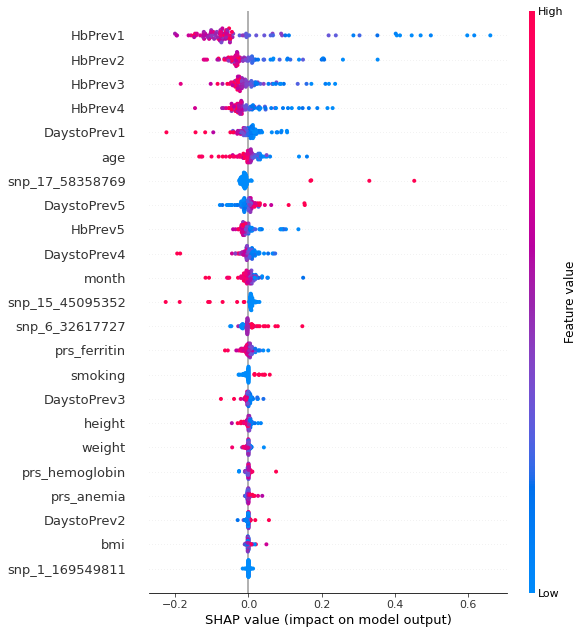

In [14]:
Xshap = pickle.load(open('../results/shap/Xshap_men_5_100.pkl', 'rb'))
shapvals = pickle.load(open('../results/shap/shapvals_men_5_100.pkl', 'rb'))

plt.figure(figsize=(8, 8))
fig = shap.summary_plot(shapvals, Xshap, max_display=Xshap.shape[1], show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
plt.savefig('../results/shap_plots/shapvals_men_5.png', bbox_inches='tight')
plt.show()

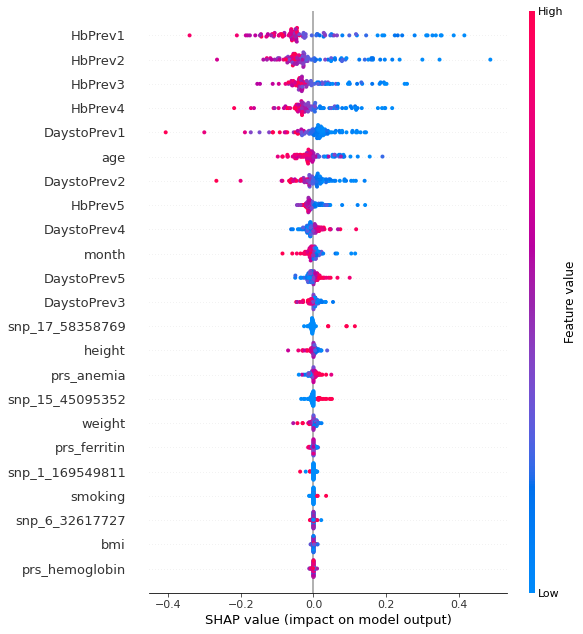

In [13]:
Xshap = pickle.load(open('../results/shap/Xshap_women_5_100.pkl', 'rb'))
shapvals = pickle.load(open('../results/shap/shapvals_women_5_100.pkl', 'rb'))

plt.figure(figsize=(8, 10))
fig = shap.summary_plot(shapvals, Xshap, max_display=Xshap.shape[1], show=False)
plt.gcf().axes[-1].set_aspect(100)
plt.gcf().axes[-1].set_box_aspect(100)
plt.savefig('../results/shap_plots/shapvals_women_5.png', bbox_inches='tight')
plt.show()

In [4]:
n = 100
path = '../results/shap/'

for nback in range(1,6):    
    for i, sex in enumerate(['men', 'women']):
        filename1 = 'Xshap_' + '_' + sex + '_' + str(nback) + '_' + str(n) + '.pkl'
        filename2 = 'shapvals'  + '_' + sex + '_' + str(nback) + '_' + str(n) + '.pkl'
        
        X_test = pickle.load(open(path+filename1, 'rb'))
        shapvals = pickle.load(open(path+filename2, 'rb'))
        
        print(sex, nback)
        plt.figure(figsize=(8, 8))
        fig = shap.summary_plot(shapvals, X_test, show=False)
        plt.gcf().axes[-1].set_aspect(100)
        plt.gcf().axes[-1].set_box_aspect(100)
        plt.savefig('../results/shap_plots/shapvals_'+sex+'_'+str(nback)+'.png', bbox_inches='tight')
        plt.close()

men 1
women 1
men 2
women 2
men 3
women 3
men 4
women 4
men 5
women 5


In [3]:
def make_preds(data, clf):
    X = data[data.columns[:-1]]
    y = data[data.columns[-1:]]
    y_pred = clf.predict(X)
    return(y_pred)

def tfpn(data):
    tp = data.loc[(data['HbOK'] == 1) & (data['HbOK_pred'] == 1), ].index.tolist()
    tn = data.loc[(data['HbOK'] == 0) & (data['HbOK_pred'] == 0), ].index.tolist()
    fp = data.loc[(data['HbOK'] == 0) & (data['HbOK_pred'] == 1), ].index.tolist()
    fn = data.loc[(data['HbOK'] == 1) & (data['HbOK_pred'] == 0), ].index.tolist()
    return(tp, tn, fp, fn)

def tfpn_df(data, orig_df):
    tp, tn, fp, fn = tfpn(data)
    tp = orig_df.iloc[tp, ].copy()
    tn = orig_df.iloc[tn, ].copy()
    fp = orig_df.iloc[fp, ].copy()
    fn = orig_df.iloc[fn, ].copy()
    return(tp, tn, fp, fn)

def plot_tfpn(df_val, plots=True):    
    tp, tn, fp, fn = tfpn_df(df_val, df)
    
    print('Average Hb in true positive:', round(tp['Hb'].mean(), 2))
    print('Average Hb in true negative:', round(tn['Hb'].mean(), 2))
    print('Average Hb in false positive:', round(fp['Hb'].mean(), 2))
    print('Average Hb in false negative:', round(fn['Hb'].mean(), 2))
    
    if (plots):
        fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharey='row')
        ax[0].set_title('Predicted good Hb')
        ax[0].set_xlabel('True Hb')
        ax[0].hist(tp['Hb'], bins=[x/10 for x in range(60, 120)], color='green')
        ax[0].hist(fp['Hb'], bins=[x/10 for x in range(60, 120)], color='red')
        ax[1].set_title('Predicted low Hb')
        ax[1].set_xlabel('True Hb')
        ax[1].hist(tn['Hb'], bins=[x/10 for x in range(60, 120)], color='green')
        ax[1].hist(fn['Hb'], bins=[x/10 for x in range(60, 120)], color='red')

        plt.show()
    

In [5]:
import pandas as pd
df = pd.read_pickle('X:/OneDrive/PhD/Data/202111 SVM prediction/trained_clfs_proba/proba_F_1.pkl')
df.head()

,HbOK,prob_low,prob_ok
4,1,0.085678,0.914322
20,1,0.014523,0.985477
21,1,0.008727,0.991273
80,1,0.009256,0.990744
110,1,0.006226,0.993774


In [6]:
df = pd.read_csv('X:/OneDrive/PhD/Data/202111 SVM prediction/df_5f.csv')
df.head()

,KeyID,Sex,DoB,EIN,Date,Time,Center,DonType,BP_sys,BP_dia,...,TimetoPrev2,HbPrev3,TimetoPrev3,HbPrev4,TimetoPrev4,HbPrev5,TimetoPrev5,Last_Fer_Date,Last_Fer,TimetoFer
0,126,F,1998-04-02,N00111900515500Z,2019-01-17,20.166667,AL A'dam Valkenburgerstra,N,122.0,76.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,258,F,2000-08-09,N00112020843900S,2020-01-15,13.283333,AL Leiden,N,108.0,60.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,291,F,1969-08-21,N00182004960900D,2020-08-03,18.333333,AD490,N,115.0,75.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,291,F,1969-08-21,N00182007094800N,2020-09-28,19.933333,AD490,V,105.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-03,40.0,56.0
4,291,F,1969-08-21,N00182102062500J,2021-02-15,18.516667,AD490,V,115.0,74.0,...,196.0,NaN,NaN,NaN,NaN,NaN,NaN,2020-08-03,40.0,196.0
